# Songs Popularity Prediction

## Obiettivo 
L'obiettivo di questo progetto è la creazione di un modello in grado di predire la popolarità di una canzone sulla base di alcuni suoi parametri, quali il genere, la durata e l'anno di uscita, e sulla base di alcuni parametri che riguardano l'artista che l'ha creata. 

## Dataset
L'idea per il progetto è nata da questo dataset trovato su Kaggle a questo indirizzo https://www.kaggle.com/datasets/conorvaneden/best-songs-on-spotify-for-every-year-2000-2023, il quale contiene dati sulle 100 canzoni più popolari per ogni anno dal 2000 al 2023, per un totale di 2385 record.

Abbiamo poi deciso di integrare questo dataset di base con altre canzoni prese da varie playlist di Spotify, così da impedire che potenziali *bias* presenti nel dataset di partenza incidano negativamente sull'efficacia delle predizioni.

## Implementazione

In [591]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Descrizione features

Carichiamo il dataset di Kaggle dal file csv e mostriamone le prime righe.

In [592]:
songs = pd.read_csv("kaggle_songs.csv", sep=";")
songs.head(10)

,title,artist,top genre,year,bpm,energy,danceability,dB,liveness,valence,duration,acousticness,speechiness,popularity
0,Flowers,Miley Cyrus,pop,2023,118,68,71,-4,3,65,200,6,7,98
1,Cupid - Twin Ver.,FIFTY FIFTY,k-pop girl group,2023,120,59,78,-8,35,73,174,44,3,97
2,BESO,ROSALÍA,pop,2023,95,64,77,-7,17,53,195,74,14,96
3,Boy's a liar Pt. 2,PinkPantheress,bronx drill,2023,133,81,70,-8,25,86,131,25,5,96
4,Creepin' (with The Weeknd & 21 Savage),Metro Boomin,rap,2022,98,62,72,-6,8,17,222,42,5,96
5,Daylight,David Kushner,gen z singer-songwriter,2023,130,43,51,-9,9,32,213,83,3,96
6,TQG,KAROL G,reggaeton,2023,180,63,72,-4,9,61,199,67,28,96
7,Calm Down (with Selena Gomez),Rema,afrobeats,2022,107,81,80,-5,11,80,239,38,4,95
8,Anti-Hero,Taylor Swift,pop,2022,97,64,64,-7,14,53,201,13,5,94
9,Here With Me,d4vd,bedroom pop,2022,132,47,57,-8,13,29,242,53,3,94


Si osservi che i record del dataset sono già ordinati per popolarità decrescente.

Notare inoltre come sia stato usato un indice numerico generato automaticamente da pandas, poiché nessun insieme di attributi può costituire una chiave primaria in questo dataset: il titolo non può esserlo perché due canzoni diverse possono ovviamente condividere lo stesso titolo, ma anche la coppia (titolo, artista) non funziona in quanto una canzone può essere rilasciata più volte (in linea teorica anche durante lo stesso anno, per quanto molto improbabile).

Questa è la descrizione del significato delle variabili data dal sito http://organizeyourmusic.playlistmachinery.com/ utilizzato dal creatore del dataset:
- Genre - the genre of the track
- Year - the release year of the recording. Note that due to vagaries of releases, re-releases, re-issues and general madness, sometimes the release years are not what you'd expect.
- Beats Per Minute (BPM) - The tempo of the song.
- Energy - The energy of a song - the higher the value, the more energetic the song is.
- Danceability - The higher the value, the easier it is to dance to this song.
- Loudness (dB) - The higher the value, the louder the song.
- Liveness - The higher the value, the more likely the song is a live recording.
- Valence - The higher the value, the more positive mood for the song.
- Length - The duration of the song.
- Acousticness - The higher the value the more acoustic the song is.
- Speechiness - The higher the value the more spoken word the song contains.
- Popularity - The higher the value the more popular the song *currently* is.
- Duration - The length of the song.

La definizione di alcune variabili, come _energy_, _danceability_, _valence_ e _popularity_, appare piuttosto vaga e soggettiva. In assenza di dettagli su come sono calcolate, sarà necessario considerarne i valori per avere una idea più precisa del significato.

Nel nome delle colonne *speechiness* e *danceability* è presente uno spazio di troppo, che va rimosso.

In [593]:
songs.columns = songs.columns.str.replace('speechiness ', 'speechiness').str.replace('danceability ', 'danceability')

Aggiungiamo ora le canzoni delle altre playlist.

In [594]:
naughts = pd.read_csv("2000s.csv", sep=",")
tens = pd.read_csv("2010s.csv", sep=",")
twenties = pd.read_csv("2020s.csv", sep=",")
now = pd.read_csv("now.csv", sep=",")

new_songs = pd.concat([naughts, tens, twenties, now])

In [595]:
new_songs.drop(labels=["Unnamed: 0", "sel", "Unnamed: 2", "added"], axis=1, inplace=True)
new_songs = new_songs[new_songs["top genre"] != "uk drill"]
new_songs.dropna(axis=0, how="any", inplace=True)
new_songs.columns = songs.columns

In [596]:
new_songs["bpm"] = new_songs["bpm"].map(lambda elem: int(elem))
new_songs["energy"] = new_songs["energy"].map(lambda elem: int(elem))
new_songs["danceability"] = new_songs["danceability"].map(lambda elem: int(elem))
new_songs["dB"] = new_songs["dB"].map(lambda elem: int(elem))
new_songs["liveness"] = new_songs["liveness"].map(lambda elem: int(elem))
new_songs["valence"] = new_songs["valence"].map(lambda elem: int(elem))
new_songs["acousticness"] = new_songs["acousticness"].map(lambda elem: int(elem))
new_songs["speechiness"] = new_songs["speechiness"].map(lambda elem: int(elem))

In [597]:
new_songs

,title,artist,top genre,year,bpm,energy,danceability,dB,liveness,valence,duration,acousticness,speechiness,popularity
0,Yellow,Coldplay,permanent wave,2000,173,66,43,-7,23,28,267,0,3,93
1,Without Me,Eminem,detroit hip hop,2002,112,67,91,-3,24,66,290,0,7,91
2,The Real Slim Shady,Eminem,detroit hip hop,2000,105,66,95,-4,5,76,284,3,6,90
3,In the End,Linkin Park,alternative metal,2000,105,86,56,-6,21,40,217,1,6,89
4,The Scientist,Coldplay,permanent wave,2002,146,44,56,-7,11,21,310,73,2,88
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2292,La Vecinita,Vico C,latin hip hop,2018,94,64,93,-6,6,85,266,8,26,0
2295,Yo Te Pidere',Los Reyes,northern irish punk,2018,118,89,64,-7,5,73,182,15,4,0
2304,Rumba Habana,DJ Sanny J,italo dance,2018,127,87,82,-5,6,77,396,2,12,0
2311,El Doctorado - Remix,Tony Dize,reggaeton,2019,120,71,74,-7,29,74,265,15,5,0


In [598]:
indices_to_drop = []
for i, duration in enumerate(new_songs["duration"]):
    if type(duration) == str:
        try:
            int(duration)
        except:
            indices_to_drop.append(i)

In [599]:
new_songs.drop(indices_to_drop, axis=0, inplace=True)
new_songs = new_songs.reset_index(drop=True)

In [600]:
songs = pd.concat([songs, new_songs])

In [601]:
songs

,title,artist,top genre,year,bpm,energy,danceability,dB,liveness,valence,duration,acousticness,speechiness,popularity
0,Flowers,Miley Cyrus,pop,2023,118,68,71,-4,3,65,200,6,7,98
1,Cupid - Twin Ver.,FIFTY FIFTY,k-pop girl group,2023,120,59,78,-8,35,73,174,44,3,97
2,BESO,ROSALÍA,pop,2023,95,64,77,-7,17,53,195,74,14,96
3,Boy's a liar Pt. 2,PinkPantheress,bronx drill,2023,133,81,70,-8,25,86,131,25,5,96
4,Creepin' (with The Weeknd & 21 Savage),Metro Boomin,rap,2022,98,62,72,-6,8,17,222,42,5,96
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9058,La Vecinita,Vico C,latin hip hop,2018,94,64,93,-6,6,85,266,8,26,0
9059,Yo Te Pidere',Los Reyes,northern irish punk,2018,118,89,64,-7,5,73,182,15,4,0
9060,Rumba Habana,DJ Sanny J,italo dance,2018,127,87,82,-5,6,77,396,2,12,0
9061,El Doctorado - Remix,Tony Dize,reggaeton,2019,120,71,74,-7,29,74,265,15,5,0


### Analisi esplorativa

Dividiamo le feature in testuali e numeriche.

In [602]:
string_columns = songs.select_dtypes(include=["object"]).columns
numeric_columns = songs.select_dtypes(include=["number"]).columns

In [603]:
print("String columns: ", list(string_columns))
print("Numeric columns: ", list(numeric_columns))

String columns:  ['title', 'artist', 'top genre', 'duration']
Numeric columns:  ['year', 'bpm', 'energy', 'danceability', 'dB', 'liveness', 'valence', 'acousticness', 'speechiness', 'popularity']


Con la funzione **describe** otteniamo una prima visualizzazione numerica della distribuzione dei dati all'interno del dataset.

In [604]:
songs.describe()

,year,bpm,energy,danceability,dB,liveness,valence,acousticness,speechiness,popularity
count,11448.000000,11448.000000,11448.000000,11448.000000,11448.00000,11448.000000,11448.000000,11448.000000,11448.000000,11448.000000
mean,2013.119672,122.280835,70.847222,64.315077,-6.21471,18.633211,51.822240,17.086129,10.977463,58.825035
std,6.541506,27.464478,18.264195,16.059997,2.69186,14.582728,23.389615,22.517433,10.694754,18.503123
min,1985.000000,52.000000,4.000000,9.000000,-25.00000,1.000000,3.000000,0.000000,2.000000,0.000000
25%,2008.000000,100.000000,59.000000,54.000000,-7.00000,9.000000,34.000000,1.000000,4.000000,48.000000
50%,2015.000000,123.000000,73.000000,66.000000,-6.00000,13.000000,52.000000,7.000000,6.000000,62.000000
75%,2018.000000,139.000000,85.000000,76.000000,-4.00000,24.000000,70.000000,25.000000,13.000000,73.000000
max,2023.000000,236.000000,100.000000,99.000000,0.00000,97.000000,98.000000,99.000000,88.000000,98.000000


Vediamo come molte variabili, tra cui la label _popularity_, abbiano valori verosimilmente compresi tra 0 e 100. 

Notiamo poi come l'anno di pubblicazione meno recente sia il 1985. Non si tratta necessariamente di un errore nei dati, in quanto il dataset contiene le canzoni più _popolari_ per ogni anno dal 2000 al 2023, ma chiaramente la data di uscita delle canzoni non è limitata a questo periodo. Tuttavia, si è deciso di rimuovere tutte le canzoni precedenti all'anno 2000, che rappresentano outlier.

In [605]:
songs = songs[songs["year"] >= 2000]
songs = songs.reset_index(drop=True)
songs

,title,artist,top genre,year,bpm,energy,danceability,dB,liveness,valence,duration,acousticness,speechiness,popularity
0,Flowers,Miley Cyrus,pop,2023,118,68,71,-4,3,65,200,6,7,98
1,Cupid - Twin Ver.,FIFTY FIFTY,k-pop girl group,2023,120,59,78,-8,35,73,174,44,3,97
2,BESO,ROSALÍA,pop,2023,95,64,77,-7,17,53,195,74,14,96
3,Boy's a liar Pt. 2,PinkPantheress,bronx drill,2023,133,81,70,-8,25,86,131,25,5,96
4,Creepin' (with The Weeknd & 21 Savage),Metro Boomin,rap,2022,98,62,72,-6,8,17,222,42,5,96
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11396,La Vecinita,Vico C,latin hip hop,2018,94,64,93,-6,6,85,266,8,26,0
11397,Yo Te Pidere',Los Reyes,northern irish punk,2018,118,89,64,-7,5,73,182,15,4,0
11398,Rumba Habana,DJ Sanny J,italo dance,2018,127,87,82,-5,6,77,396,2,12,0
11399,El Doctorado - Remix,Tony Dize,reggaeton,2019,120,71,74,-7,29,74,265,15,5,0


Andiamo ora più nel dettaglio e vediamo se esiste qualche correlazione rilevante tra le feature. La funzione **scatter_matrix** permette di ottenere una matrice nella quale ogni cella non diagonale contiene uno *scatter plot* di due feature (numeriche) del dataset. Nelle celle diagonali vengono invece mostrati gli istogrammi dei valori delle feature.

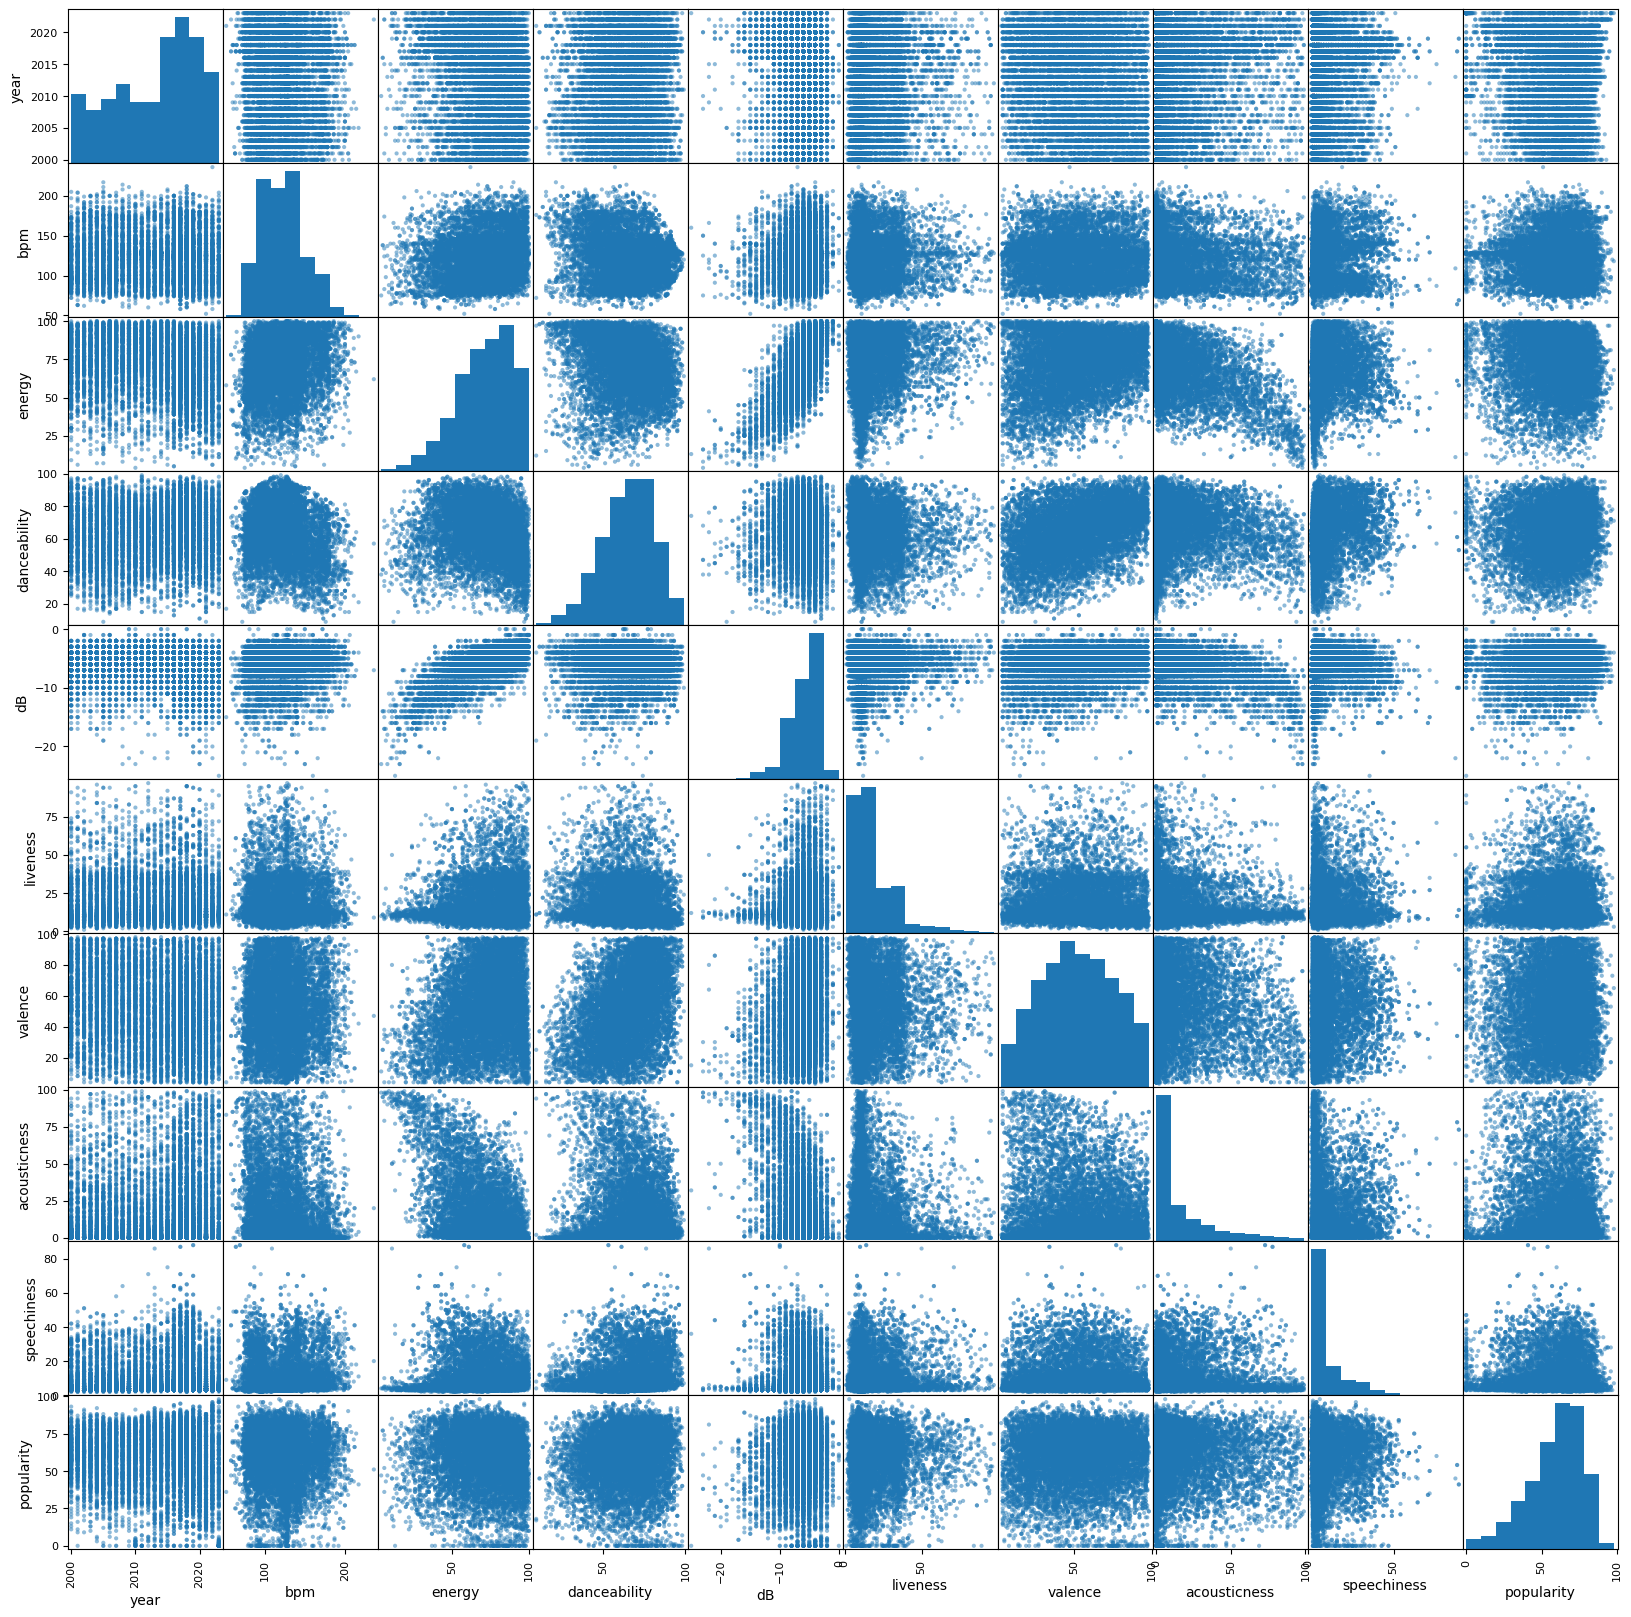

In [606]:
from pandas.plotting import scatter_matrix

scatter_matrix(songs[numeric_columns], figsize=(20, 20));

Osserviamo come ci sia una correlazione positiva tra anno di pubblicazione e popolarità attuale, proprio come ci si aspetterebbe. Un'altra correlazione positiva molto evidente è quella tra "energia" e intensità di volume in _dB_, anch'essa abbastanza ovvia.

Siccome molte correlazioni nel grafico precedente non appaiono chiare, utilizziamo la funzione **corr** dei DataFrame di **pandas** per creare una tabella a doppia entrata che mostri a livello numerico la correlazione tra una feature e ciascuna delle altre, secondo il *coefficiente di Pearson*.

<Figure size 2000x2000 with 0 Axes>

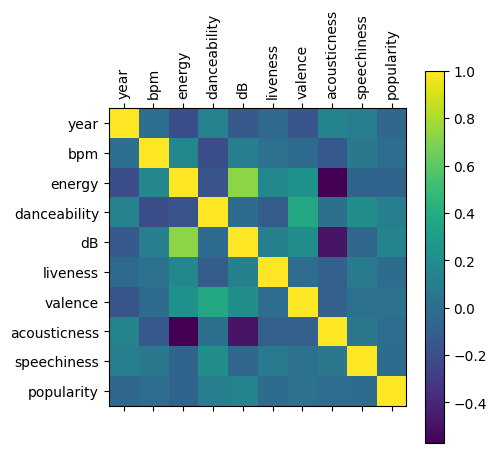

In [607]:
corr = songs.corr(numeric_only=True, method="pearson")
plt.figure(figsize=(20, 20))
plt.matshow(corr)
plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
plt.yticks(range(len(corr.columns)), corr.columns)
plt.colorbar()
plt.show()

Sorprendentemente, la popolarità di una canzone sembra correlata in maniera sensibile solo con l'anno di pubblicazione, e con nessuna delle caratteristiche intrinseche della canzone stessa, come ad esempio la sua energià, danzabilità e durata.

Ad ulteriore riprova, mostriamo la correlazione delle feature numeriche con la variabile _popularity_.

In [608]:
corr = songs[numeric_columns].corr()
corr["popularity"].sort_values(ascending=False)

popularity      1.000000
dB              0.131601
danceability    0.103514
valence         0.018687
bpm            -0.002739
acousticness   -0.011648
liveness       -0.014002
speechiness    -0.016940
year           -0.054919
energy         -0.067737
Name: popularity, dtype: float64

Infine, vediamo la distribuzione di generi e artisti.

In [609]:
songs["top genre"].value_counts()

dance pop             819
alternative metal     529
atl hip hop           389
pop                   367
alternative rock      319
                     ... 
dutch metal             1
post-teen pop           1
swedish americana       1
progressive sludge      1
french hip hop          1
Name: top genre, Length: 798, dtype: int64

In [610]:
(songs["top genre"].value_counts() == 1).sum() / songs["top genre"].value_counts().count()

0.2706766917293233

I generi sono estremamente specifici, in quanto ci sono caratterizzazioni regionali all'interno di ciascun genere. Addirittura, il 36% di tutti i generi presenti nel dataset compare con una sola canzone.

In [611]:
songs["artist"].value_counts()

Kendrick Lamar       90
Kanye West           82
Drake                71
Calvin Harris        61
Eminem               52
                     ..
Conor Oberst          1
Magnate               1
Paul Motian           1
Silkk The Shocker     1
Booba                 1
Name: artist, Length: 3273, dtype: int64

In [612]:
songs["artist"].count() / songs["artist"].value_counts().count()

3.4833486098380693

Anche gli artisti sono molti rispetto al numero di canzoni totali. Mediamente, ogni artista è presente con 2.35 canzoni all'interno del dataset.

### Integrazione del dataset con altre fonti

#### NLP

Si è ritenuto necessario considerare per ogni canzone anche il suo testo, il cui contenuto, opportunamente processato con tecniche di Natural Language Processing, può essere di aiuto per predirne la popolarità.
Abbiamo dunque fatto uso della libreria *lyricsgenius*, che tramite l'API del sito https://genius.com/ permette di scaricare il testo di una canzone dato il titolo e l'autore.

Di seguito è possibile trovare il codice (commentato) che implementa questa operazione. Si noti tuttavia che l'esecuzione richede molto tempo (almeno un'ora), in quanto le richieste vanno spesso in timeout. Non è comunque necessario eseguire le celle seguenti, in quanto i testi sono già stati scaricati e si trovano nel file *songs_lyrics.csv*. 

In [613]:
# %pip install lyricsgenius
# import lyricsgenius as lg

In [614]:
import csv

"""
access_token = '8yvpmDv96aodI5vg660Afcby4XPdrhPrx4JCAM3souNcRYG9C2nF5TWg1'
genius = lg.Genius(access_token)

def get_lyrics(song_title, artist_name):
    song = genius.search_song(song_title, artist_name)
    return song.lyrics if song is not None else ""

songs = pd.read_csv("songs.csv", sep=";")

with open("songs_lyrics.csv", "a", newline="", encoding="utf-8") as csv_file:
    writer = csv.writer(csv_file, delimiter="|")
    writer.writerow(["title", "artist", "lyrics"])
    for _, song in songs.iterrows():
        is_ok = False
        while not is_ok:
            try:
                lyrics = get_lyrics(song.title, song.artist)
                is_ok = True
                writer.writerow([song.title, song.artist, lyrics])
            except Exception as e:
                continue
""";

Carichiamo e mostriamo il nuovo dataset contenente le _lyrics_ delle canzoni.

In [615]:
songs_lyrics = pd.read_csv("songs_lyrics.csv", sep="|", na_values={"": None}, keep_default_na=False)
songs_lyrics

,title,artist,lyrics
0,Flowers,Miley Cyrus,88 ContributorsTranslationsEspañolPortuguêsKis...
1,Cupid - Twin Ver.,FIFTY FIFTY,1 ContributorTranslationsEnglishBahasa MelayuF...
2,BESO,ROSALÍA,29 ContributorsTranslationsPortuguêsEnglishDeu...
3,Boy's a liar Pt. 2,PinkPantheress,92 ContributorsTranslationsPortuguêsTürkçeDeut...
4,Creepin' (with The Weeknd & 21 Savage),Metro Boomin,2 ContributorsNew Music Friday 12/02/22 Lyrics...
...,...,...,...
2380,Southbound,Beach Blvd,2 ContributorsMe & My Skate Lyrics[Skit]\nOh s...
2381,Dance with Somebody - Radio Version,Mando Diao,1 ContributorDance With Somebody - Radio Versi...
2382,Flow,Desire Machines,1 ContributorWhat Matters? Lyrics[Hook]\nLeave...
2383,Scared of the Dark,Everything Brighter,1 ContributorWay Home LyricsYa Ya Ya\n\nI hear...


Per alcune canzoni, l'API di Genius non fornisce alcun testo.

In [616]:
print(f"Ci sono {(songs_lyrics['lyrics'] == '').sum()} canzoni di cui non è stato trovato il testo.")
songs_lyrics[songs_lyrics["lyrics"] == ''].head(10)

Ci sono 54 canzoni di cui non è stato trovato il testo.


,title,artist,lyrics
16,Until I Found You (with Em Beihold) - Em Beiho...,Stephen Sanchez,
317,"Happy - From ""Despicable Me 2""",Pharrell Williams,
339,"Moves Like Jagger - Studio Recording From ""The...",Maroon 5,
446,CAN'T STOP THE FEELING! (from DreamWorks Anima...,Justin Timberlake,
684,Valerie (feat. Amy Winehouse) - Version Revisited,Mark Ronson,
686,Waka Waka (This Time for Africa) [The Official...,Shakira,
905,Free Fallin' - Live at the Nokia Theatre Los A...,John Mayer,
912,Intro,The xx,
947,Summertime Sadness (Lana Del Rey Vs. Cedric Ge...,Lana Del Rey,
1086,Jenny from the Block (feat. Jadakiss & Styles ...,Jennifer Lopez,


In generale, i testi scaricati sono "sporchi", cioè contengono messaggi da parte dell'API che però non fanno parte del testo della canzone. 

In [617]:
songs_lyrics["lyrics"][0]

"88 ContributorsTranslationsEspañolPortuguêsKiswahiliDeutschItalianoСрпскиNederlandsSvenskaPolskiTürkçeΕλληνικάFrançaisDanskРусскийالعربيةУкраїнськаBahasa IndonesiaFlowers Lyrics[Verse 1]\nWe were good, we were gold\nKinda dream that can't be sold\nWe were right 'til we weren't\nBuilt a home and watched it burn\n\n[Pre-Chorus]\nMm, I didn't wanna leave you, I didn't wanna lie\nStarted to cry, but then remembered I\n\n[Chorus]\nI can buy myself flowers\nWrite my name in the sand\nTalk to myself for hours\nSay things you don't understand\nI can take myself dancing\nAnd I can hold my own hand\nYeah, I can love me better than you can\n\n[Post-Chorus]\nCan love me better, I can love me better, baby\nCan love me better, I can love me better, baby\n\n[Verse 2]\nPaint my nails cherry-red\nMatch the roses that you left\nNo remorse, no regret\nI forgive every word you said\nYou might also like[Pre-Chorus]\nOoh, I didn't wanna leave you, baby, I didn't wanna fight\nStarted to cry, but then rememb

Molti dei testi che hanno pochi "contributors" (meno di 20) sono sbagliati: la seguente funzione permette di rimuoverli, cioè di assegnare ad essi il valore stringa vuota (''). Inoltre, rimuove dai testi validi le parti di stringa che non corrispondono al reale testo della canzone. 

In [618]:
def clean_lyrics(text):
    if text != '':
        contributors, other = text.split("Contributor")
        text = other.split("Lyrics")[1].split("Embed")[0] if int(contributors) > 20 else ''
    return text

In [619]:
songs_lyrics["lyrics"] = songs_lyrics["lyrics"].map(clean_lyrics)

In [620]:
print(f"Ci sono {(songs_lyrics['lyrics'] == '').sum()} canzoni di cui non è stato trovato il testo.")
songs_lyrics[songs_lyrics["lyrics"] == ''].head(10)

Ci sono 775 canzoni di cui non è stato trovato il testo.


,title,artist,lyrics
1,Cupid - Twin Ver.,FIFTY FIFTY,
4,Creepin' (with The Weeknd & 21 Savage),Metro Boomin,
7,Calm Down (with Selena Gomez),Rema,
12,Die For You - Remix,The Weeknd,
16,Until I Found You (with Em Beihold) - Em Beiho...,Stephen Sanchez,
29,Unholy (feat. Kim Petras),Sam Smith,
36,La Bachata,Manuel Turizo,
38,lovely (with Khalid),Billie Eilish,
46,Yandel 150,Yandel,
50,Double Fantasy (with Future),The Weeknd,


Il numero di canzoni che non possiedono testo è aumentato significativamente. Purtroppo questo problema è dovuto alle risposte fornite dall'API di Genius, quindi non è risolvibile a meno di non utilizzare un'altra API.

A questo punto il dataset è pronto per essere processato. Importiamo quindi le librerie necessarie per il NLP.

In [621]:
%pip install nltk
import nltk

%pip install langdetect
from langdetect import detect

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


Per prima cosa, aggiungiamo al DataFrame una colonna contenente la lingua in cui è cantata la canzone, utilizzando la funzione **detect** del package **langdetect**.

In [622]:
def detect_language(text):
    return detect(text) if text != '' else None

In [623]:
songs_lyrics["language"] = songs_lyrics["lyrics"].map(detect_language)
songs_lyrics

,title,artist,lyrics,language
0,Flowers,Miley Cyrus,"[Verse 1]\nWe were good, we were gold\nKinda d...",en
1,Cupid - Twin Ver.,FIFTY FIFTY,,None
2,BESO,ROSALÍA,"[Letra de ""BESO""]\n\n[Coro: ROSALÍA]\nYa yo ne...",es
3,Boy's a liar Pt. 2,PinkPantheress,[Verse 1: PinkPantheress]\nTake a look inside ...,en
4,Creepin' (with The Weeknd & 21 Savage),Metro Boomin,,None
...,...,...,...,...
2380,Southbound,Beach Blvd,,None
2381,Dance with Somebody - Radio Version,Mando Diao,,None
2382,Flow,Desire Machines,,None
2383,Scared of the Dark,Everything Brighter,,None


Notare come le canzoni senza testo o il cui testo è stato precedentemente scartato a causa dei pochi "contributors" abbiano il valore **None** nella colonna **language**.

La distribuzione dei valori mostra come la stragrande maggioranza delle canzoni che possiedono un testo "valido" siano in lingua inglese. Questo è presumibilmente dovuto al fatto che Genius è un sito americano e quindi fruito prevalentemente da anglofoni.

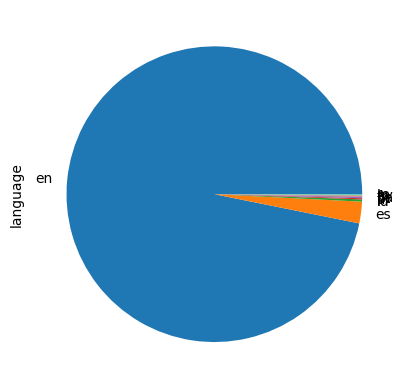

In [624]:
songs_lyrics["language"].value_counts().plot.pie();

Aggiungiamo al dataset la colonna _popularity_ presa dal dataset principale.

In [625]:
songs_lyrics["popularity"] = songs["popularity"]
songs_lyrics

,title,artist,lyrics,language,popularity
0,Flowers,Miley Cyrus,"[Verse 1]\nWe were good, we were gold\nKinda d...",en,98
1,Cupid - Twin Ver.,FIFTY FIFTY,,None,97
2,BESO,ROSALÍA,"[Letra de ""BESO""]\n\n[Coro: ROSALÍA]\nYa yo ne...",es,96
3,Boy's a liar Pt. 2,PinkPantheress,[Verse 1: PinkPantheress]\nTake a look inside ...,en,96
4,Creepin' (with The Weeknd & 21 Savage),Metro Boomin,,None,96
...,...,...,...,...,...
2380,Southbound,Beach Blvd,,None,84
2381,Dance with Somebody - Radio Version,Mando Diao,,None,84
2382,Flow,Desire Machines,,None,84
2383,Scared of the Dark,Everything Brighter,,None,84


Creiamo ora un dataset che contenga solo le canzoni con testo valido, da usare nell'addestramento e nella validazione di modelli predittivi che facciano uso di tecniche di NLP.

In [626]:
valid_songs_lyrics = songs_lyrics[songs_lyrics["lyrics"] != '']
valid_songs_lyrics

,title,artist,lyrics,language,popularity
0,Flowers,Miley Cyrus,"[Verse 1]\nWe were good, we were gold\nKinda d...",en,98
2,BESO,ROSALÍA,"[Letra de ""BESO""]\n\n[Coro: ROSALÍA]\nYa yo ne...",es,96
3,Boy's a liar Pt. 2,PinkPantheress,[Verse 1: PinkPantheress]\nTake a look inside ...,en,96
5,Daylight,David Kushner,[Verse 1]\nTelling myself I won't go there\nOh...,en,96
6,TQG,KAROL G,"[Letra de ""TQG""]\n\n[Intro: KAROL G]\nLa que t...",es,96
...,...,...,...,...,...
2349,Lips Of An Angel,Hinder,"[Verse 1]\nHoney, why you callin’ me so late?\...",en,88
2351,Fake It,Seether,[Verse 1]\nWho's to know if your soul will fad...,en,87
2355,Switch,Will Smith,"[Intro]\nYo mic check, mic check, yeah here yo...",en,86
2361,The Selfish Gene,Marlon Percy,"5/1\n11:11 - ""Me, Chanel & Jameson""\nAazar & Y...",en,85


Costruiamo un semplice modello di tipo Bag of Words, così da avere una prima idea approssimativa di quanto la presenza di parole ricorrenti all'interno del testo di una canzone ne influenzi la popolarità. Facendo uso di un'istanza di **CountVectorizer**, possiamo creare una matrice testi-parole, nella quale ogni riga rappresenta una canzone e ogni colonna una parola che compare in almeno 15 canzoni. Questa soglia minima è stata aggiunta così da ridurre la dimensionalità dello spazio vettoriale. Inoltre, vengono anche rimosse le cosiddette _stopwords_ dai testi in lingua inglese.

Sulla matrice così creata viene effettuata una somma sulle colonne, il cui risultato è un vettore che associa ad ogni canzone la quantità di parole comuni che compaiono nel suo testo.

In [627]:
from sklearn.feature_extraction.text import CountVectorizer

cvect = CountVectorizer(min_df=15, stop_words="english")
mat = cvect.fit_transform(valid_songs_lyrics["lyrics"])
lyric_popularity = mat.toarray().sum(axis=1)

In [628]:
np.corrcoef(lyric_popularity, valid_songs_lyrics["popularity"])

array([[ 1.        , -0.15209792],
       [-0.15209792,  1.        ]])

Questo risultato mostra come sia presente una leggera correlazione negativa tra il vettore contenente le "popolarità dei testi" e quello contenente i valori di popolarità delle canzoni. Si tratta di un risultato certamente interessante, ma sarebbe sbagliato trarre la conclusione che un testo "banale" implica una minor popolarità della canzone.

In effetti, si è scelto di non includere per nulla questa feature nel dataset principale, sia perché i suoi valori dipendono fortemente da quali canzoni fanno parte del dataset in uso, sia per la difficoltà di gestire le canzoni che non hanno testo.

Si è quindi deciso di provare a cercare un insieme di termini _significativi_, ovvero parole la cui presenza influenzi positivamente o negativamente la popolarità della canzone. Per fare ciò, si è fatto uso di un modello di regressione con regolarizzazione **LASSO**, in modo tale che l'insieme di parole desiderato sia dato da tutte le parole il cui coefficiente all'interno del modello sia diverso da 0.  

In [629]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(valid_songs_lyrics["lyrics"], valid_songs_lyrics["popularity"], 
                                                    test_size=1/3, random_state=42)

In [630]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error

def print_eval(model, X, y_true):
    y_pred = model.predict(X)
    print(f"R2: {r2_score(y_true, y_pred):.3f}")
    print(f"RMSE: {np.sqrt(mean_squared_error(y_true, y_pred, squared=True)):.3f}")
    print(f"MAE: {mean_absolute_error(y_true, y_pred):.3f}")
    print(f"MAPE: {mean_absolute_percentage_error(y_true, y_pred):.3%}")

Questa funzione crea un dizionario che associa ad ogni parola il suo coefficiente nel modello, a patto che esso sia superiore ad una data soglia.

In [631]:
def create_features_dict(model, threshold):
    features = model["vect"].get_feature_names_out()
    # Valid words is the number of words included in the vector space.
    print("Valid words:", len(features))
    coefs = model["regr"].coef_
    features_coefs = {features[i]: coefs[i] for i in range(len(features)) if abs(coefs[i]) > threshold}
    # Valuable words is the number of words whose coefficient is greater than a given threshold.
    print("Valuable words:", len(features_coefs))
    return features_coefs

Definiamo il modello e testiamolo con un valore di **alpha** basso. 

Ciascuna istanza di modello testata fa uso di un **CountVectorizer** che ignora le _stopword_ inglesi. Inoltre, si è preferito non dichiarare nessun valore per *min_df*, poiché esso avrebbe introdotto un bias implicito dovuto alla maggior presenza di testi inglesi nel dataset.

In [632]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Lasso

model = Pipeline([
    ("vect", CountVectorizer(stop_words="english")),
    ("regr", Lasso(alpha=0.1))
])

model.fit(X_train, y_train)
print_eval(model, X_val, y_val)
features_coefs = create_features_dict(model, threshold=0.01)
features_coefs, model["regr"].intercept_

R2: -0.220
RMSE: 10.994
MAE: 8.251
MAPE: 12.517%
Valid words: 16917
Valuable words: 449


({'10': -0.3813838170027861,
  '21': 0.3673036215999154,
  'aah': -0.17754814139057612,
  'adios': -0.7770046184900194,
  'ah': 0.10019651827710863,
  'ain': -0.23621544402542474,
  'alarm': -0.14958359875549326,
  'angel': 0.4232905521434098,
  'apart': -0.21174549747749533,
  'ask': -0.47035323396141915,
  'aw': 0.07219648953616413,
  'ay': -0.18612690612533328,
  'ayy': 0.018834877245500134,
  'ayyy': 0.043006163001722296,
  'babe': 0.14199379809492882,
  'bad': -0.18289142354286167,
  'badoom': 0.1315706161893652,
  'bag': -0.1531758517634695,
  'bah': -0.23987490671680547,
  'bailando': -0.06268702993766277,
  'ball': 0.16517275520050315,
  'ballin': -0.15254717483783325,
  'balvin': -0.012442251225913583,
  'bang': 0.0754081372944673,
  'beat': -0.08152731446661075,
  'beep': -0.16300351424489748,
  'beggin': 0.07562577198386648,
  'believe': -0.041946085579059524,
  'belong': -0.07393967491730773,
  'bennington': 0.3190957925306694,
  'best': -0.14259804448204408,
  'better': 0.

Ovviamente, se **alpha** è prossimo a 0 (come nel modello soprastante) le parole considerate significative dal modello saranno tante. 

Proviamo un valore di **alpha** maggiore.

In [633]:
model = Pipeline([
    ("vect", CountVectorizer(stop_words="english")),
    ("regr", Lasso(alpha=1))
])

model.fit(X_train, y_train)
print_eval(model, X_val, y_val)
features_coefs = create_features_dict(model, threshold=0.01)
features_coefs, model["regr"].intercept_

R2: 0.029
RMSE: 9.810
MAE: 7.622
MAPE: 11.690%
Valid words: 16917
Valuable words: 33


({'10': -0.17745691666808372,
  'ah': 0.08554401938951074,
  'ain': -0.12289385424597718,
  'bah': -0.10674907506826714,
  'bitch': -0.01669495746663426,
  'chorus': 0.023372922925235236,
  'don': -0.10095845432588989,
  'doo': -0.09477469131747789,
  'faded': -0.1308952921558031,
  'feel': 0.039657849251752954,
  'fly': -0.08142706973953316,
  'ft': 0.027680353653907502,
  'girl': -0.08355626483092334,
  'got': -0.06969933968376997,
  'ha': 0.05404947450662752,
  'hey': -0.04769457252843092,
  'hold': -0.15202708754451594,
  'hot': -0.01236110925864328,
  'know': -0.08855348596727639,
  'low': -0.05380149076140928,
  'make': -0.12015783910556399,
  'man': -0.19707100895005786,
  'nigga': -0.11974224205687406,
  'oh': -0.015435250126025394,
  'ooh': 0.02579096263852435,
  'que': 0.24081871569212562,
  'right': -0.02007888461652252,
  'rock': -0.11517914539524193,
  'said': 0.047055451350601414,
  'thing': -0.15040906527060532,
  'throw': -0.11447555692847722,
  'wanna': -0.031327939251

Aumentando il parametro **alpha** da 0.01 a 1, le parole significative si riducono di più di 15 volte. Tuttavia, il risultato appare ancora poco soddisfacente, in quanto tali parole sembrano piuttosto casuali e i coefficienti sono molto piccoli. 

Proviamo ad aumentare ancora il valore di **alpha**.

In [634]:
model = Pipeline([
    ("vect", CountVectorizer(stop_words="english")),
    ("regr", Lasso(alpha=5))
])

model.fit(X_train, y_train)
print_eval(model, X_val, y_val)
features_coefs = create_features_dict(model, threshold=0.01)
features_coefs, model["regr"].intercept_

R2: 0.001
RMSE: 9.948
MAE: 7.857
MAPE: 12.002%
Valid words: 16917
Valuable words: 1


({'don': -0.03009867737475876}, 73.13372361355235)

Con **alpha=5**, si ottiene un modello che fa uso di sole due parole per predire la popolarità di una canzone, ovvero _don_ e _ft_. 

Le metriche di accuratezza di questo modello, così come dei precedenti, non sono incoraggianti in quanto sembra evidente che non esista un gruppo di termini in grado di influenzare la popolarità di una canzone. Inoltre, le parole individuate dal modello sono assolutamente causuali e non rappresentative di uno stile musicale o di un significato particolare.

Per questi motivi, si è deciso di non aggiungere al dataset principale nessuna nuova feature che riguardi il testo di una canzone, cosa che tra l'altro avrebbe reso complessa la gestione delle canzoni che non hanno testo. 

#### Popolarità artisti su Spotify

Abbiamo pensato di introdurre una nuova feature che rappresenti la popolarità di un'artista, dato che la popolarità di una canzone è intrinsecamente proporzionale alla popolarità dell'artista che la crea. Per coerenza con i dati presenti nel dataset, abbiamo scelto di utilizzare l'indice di popolarità di Spotify, che assegna ad ogni artista un valore tra 0 (sconosciuto) e 100 (massima popolarità).

Utilizziamo dunque la Web API fornita da Spotify, tramite una libreria Python apposita per l'interfacciamento con l'API.

Spotify Web API: https://developer.spotify.com/documentation/web-api

Libreria Spotipy: https://spotipy.readthedocs.io/en/2.22.1/#

In [635]:
%pip install spotipy
import spotipy as sp

Note: you may need to restart the kernel to use updated packages.


Il seguente codice permette di stabilire una connessione all'API e di creare un file csv che contenga le popolarità di tutti gli artisti del dataset principale. Un artista compare nel nuovo file tante volte quante sono le sue canzoni nel dataset.

Ovviamente, *client_id* e *client_secret* stati rimossi per motivi di privacy.

In [636]:
'''
client_id = 'da79c065e82a4415932904e6e05d443d'
client_secret = '38fd1dae05cc4a73ae1bdd0fdc50fb0b'

spotify = sp.Spotify(client_credentials_manager=sp.oauth2.SpotifyClientCredentials(client_id, client_secret))

def get_artist_popularity(artist_name):
    results = spotify.search(q='artist:' + artist_name, type='artist')
    items = results['artists']['items']
    return items[0]['popularity'] if len(items) > 0 else np.nan

with open("artist_popularity.csv", "a", newline="", encoding="utf-8") as csv_file:
    writer = csv.writer(csv_file, delimiter="|")
    writer.writerow(["artist", "popularity"])
    for _, song in songs.iterrows():
        is_ok = False
        while not is_ok:
            try:
                popularity = get_artist_popularity(song.artist)
                is_ok = True
                writer.writerow([song.artist, popularity])
            except Exception as e:
                continue
''';

Leggiamo poi il file csv creato e ne carichiamo i dati su un dataset, eliminando i duplicati e ordinando per popolarità.

In [637]:
artist_popularity = pd.read_csv("artist_popularity.csv", sep="|")
artist_popularity.drop_duplicates(subset="artist", inplace=True)
artist_popularity.reset_index(drop=True, inplace=True)
artist_popularity.sort_values(by="popularity", ascending=False, inplace=True)
artist_popularity.head(20)

,artist,popularity
8,Taylor Swift,100.0
18,Bad Bunny,96.0
12,The Weeknd,95.0
22,Drake,95.0
100,Lana Del Rey,91.0
4,Metro Boomin,91.0
145,Future,90.0
49,Kanye West,90.0
132,BTS,90.0
19,Eminem,90.0


Per un errore nell'API, alcuni artisti risultano senza popolarità: abbiamo deciso di rimuovere le loro canzoni dal dataset.

In [638]:
artist_popularity = artist_popularity[~artist_popularity["popularity"].isna()]
artist_popularity["popularity"] = artist_popularity["popularity"].map(lambda elem: int(elem))
artist_popularity

,artist,popularity
8,Taylor Swift,100
18,Bad Bunny,96
12,The Weeknd,95
22,Drake,95
100,Lana Del Rey,91
...,...,...
3204,Why Kai,0
985,Kodiro,0
977,Charlie Mat,0
1762,Mc Jamaica,0


Infine uniamo il dataset della popolarità degli artisti al dataset principale, rinominando la colonna *popularity* in *song popularity*.

In [639]:
artist_popularity.rename(columns={"popularity": "artist popularity"}, inplace=True)
songs.rename(columns={"popularity": "song popularity"}, inplace=True)
songs = pd.merge(songs, artist_popularity, on="artist", how="left")
songs

,title,artist,top genre,year,bpm,energy,danceability,dB,liveness,valence,duration,acousticness,speechiness,song popularity,artist popularity
0,Flowers,Miley Cyrus,pop,2023,118,68,71,-4,3,65,200,6,7,98,87.0
1,Cupid - Twin Ver.,FIFTY FIFTY,k-pop girl group,2023,120,59,78,-8,35,73,174,44,3,97,80.0
2,BESO,ROSALÍA,pop,2023,95,64,77,-7,17,53,195,74,14,96,84.0
3,Boy's a liar Pt. 2,PinkPantheress,bronx drill,2023,133,81,70,-8,25,86,131,25,5,96,79.0
4,Creepin' (with The Weeknd & 21 Savage),Metro Boomin,rap,2022,98,62,72,-6,8,17,222,42,5,96,91.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11396,La Vecinita,Vico C,latin hip hop,2018,94,64,93,-6,6,85,266,8,26,0,63.0
11397,Yo Te Pidere',Los Reyes,northern irish punk,2018,118,89,64,-7,5,73,182,15,4,0,46.0
11398,Rumba Habana,DJ Sanny J,italo dance,2018,127,87,82,-5,6,77,396,2,12,0,27.0
11399,El Doctorado - Remix,Tony Dize,reggaeton,2019,120,71,74,-7,29,74,265,15,5,0,71.0


### Preparazione dataset

Dato che il dataset calcola la popolarità attuale, convertiamo l'anno di uscita nell'età della canzone rispetto all'anno corrente.

In [640]:
import datetime

current_year = datetime.date.today().year
songs["year"] = current_year - songs["year"]
songs.rename(columns={"year": "age"}, inplace=True)
songs

,title,artist,top genre,age,bpm,energy,danceability,dB,liveness,valence,duration,acousticness,speechiness,song popularity,artist popularity
0,Flowers,Miley Cyrus,pop,0,118,68,71,-4,3,65,200,6,7,98,87.0
1,Cupid - Twin Ver.,FIFTY FIFTY,k-pop girl group,0,120,59,78,-8,35,73,174,44,3,97,80.0
2,BESO,ROSALÍA,pop,0,95,64,77,-7,17,53,195,74,14,96,84.0
3,Boy's a liar Pt. 2,PinkPantheress,bronx drill,0,133,81,70,-8,25,86,131,25,5,96,79.0
4,Creepin' (with The Weeknd & 21 Savage),Metro Boomin,rap,1,98,62,72,-6,8,17,222,42,5,96,91.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11396,La Vecinita,Vico C,latin hip hop,5,94,64,93,-6,6,85,266,8,26,0,63.0
11397,Yo Te Pidere',Los Reyes,northern irish punk,5,118,89,64,-7,5,73,182,15,4,0,46.0
11398,Rumba Habana,DJ Sanny J,italo dance,5,127,87,82,-5,6,77,396,2,12,0,27.0
11399,El Doctorado - Remix,Tony Dize,reggaeton,4,120,71,74,-7,29,74,265,15,5,0,71.0


Creiamo un dizionario che associa i macro-generi ai sottogeneri che ne fanno parte e un dizionario che fa il contrario. Serviranno per ridurre la granularità dei generi, che al momento sono decisamente troppi e troppo specifici per essere in qualche modo rilevanti.

In [641]:
dict_genre = {
    "pop": ["pop", "boy band", "idol"],
    "rock": ["rock", "punk", "grunge", "emo", "metal"],
    "hip-hop": ["hip", "hop", "rap", "drill", "trap", "crunk", "gangsta", "grime"],
    "soul": ["r&b", "soul", "gospel", "funk"],
    "latin": ["reggaeton", "latin", "reggae", "ska"],
    "edm": ["house", "edm", "electro", "dance", "techno", "dubstep", "brostep", "trance"],
    "indie": ["indie", "folk", "alternative", "lo-fi", "acoustic", "country", "bluegrass", "americana"],
    "singer-songwriter": ["singer", "songwriter", "solo"],
    "jazz": ["jazz", "swing", "big band"]
}

In [642]:
dict_subgenre = {v: k for k, values in dict_genre.items() for v in values}

La seguente funzione permette di ottenere il genere principale di una canzone a partire dal suo sottogenere. Se il sottogenere non è tra quelli considerati rilevanti, allora il genere viene settato a "other".

In [643]:
def get_main_genre(song_genre):
    subgenres = [subgenre for subgenre in dict_subgenre.keys() if song_genre.__contains__(subgenre)]
    return dict_subgenre[subgenres[0]] if len(subgenres) > 0 else "other"

In [644]:
songs["top genre"] = songs["top genre"].map(get_main_genre)
songs["top genre"].value_counts()

pop                  2855
hip-hop              2697
rock                 1813
edm                  1189
other                1001
soul                  706
indie                 539
latin                 333
jazz                  239
singer-songwriter      29
Name: top genre, dtype: int64

Vediamo come alcuni macro-generi siano rappresentati da pochissime canzoni. Questo rischia di essere un problema in fase di addestramento di un modello che ne fa uso, poiché l'influenza di questi generi "rari" sulla popolarità sarebbe troppo legata alle singole canzoni che vi appartengono.

Aggiungiamo quindi un filtro sui generi, che li accorpa alla categoria "other" se non hanno almeno 100 istanze nel dataset **o** il numero di istanze non è almeno il 10% di tutte le istanze (queste due soglie insieme dovrebbero assicurare il funzionamento di questo metodo sia per dataset molto grandi che molto piccoli).

In [645]:
def is_genre_valid(genre):
    return songs["top genre"].value_counts()[genre] > 100 or (songs["top genre"] == genre).mean() > 0.1

songs["top genre"] = songs["top genre"].map(lambda genre: genre if is_genre_valid(genre) else "other")

In [646]:
songs["top genre"].value_counts()

pop        2855
hip-hop    2697
rock       1813
edm        1189
other      1030
soul        706
indie       539
latin       333
jazz        239
Name: top genre, dtype: int64

Ora i generi sono soltanto 8 (oltre ad "other") e tutti sono rappresentati da almeno 239 canzoni. Usiamo il **OneHotEncoding** sul genere della canzone per far sì che tale feature sia utilizzabile da un modello di predizione.

In [647]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder()
genre_one_hot = encoder.fit_transform(songs[["top genre"]].values.reshape(-1, 1))
genre_columns = encoder.categories_[0]
genre_one_hot = pd.DataFrame(genre_one_hot.toarray().astype(int), columns=genre_columns)
songs = pd.concat([songs, genre_one_hot], axis=1)
songs.drop(["top genre"], axis=1, inplace=True)

In [648]:
songs

,title,artist,age,bpm,energy,danceability,dB,liveness,valence,duration,...,artist popularity,edm,hip-hop,indie,jazz,latin,other,pop,rock,soul
0,Flowers,Miley Cyrus,0,118,68,71,-4,3,65,200,...,87.0,0,0,0,0,0,0,1,0,0
1,Cupid - Twin Ver.,FIFTY FIFTY,0,120,59,78,-8,35,73,174,...,80.0,0,0,0,0,0,0,1,0,0
2,BESO,ROSALÍA,0,95,64,77,-7,17,53,195,...,84.0,0,0,0,0,0,0,1,0,0
3,Boy's a liar Pt. 2,PinkPantheress,0,133,81,70,-8,25,86,131,...,79.0,0,1,0,0,0,0,0,0,0
4,Creepin' (with The Weeknd & 21 Savage),Metro Boomin,1,98,62,72,-6,8,17,222,...,91.0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11396,La Vecinita,Vico C,5,94,64,93,-6,6,85,266,...,63.0,0,1,0,0,0,0,0,0,0
11397,Yo Te Pidere',Los Reyes,5,118,89,64,-7,5,73,182,...,46.0,0,0,0,0,0,0,0,1,0
11398,Rumba Habana,DJ Sanny J,5,127,87,82,-5,6,77,396,...,27.0,1,0,0,0,0,0,0,0,0
11399,El Doctorado - Remix,Tony Dize,4,120,71,74,-7,29,74,265,...,71.0,0,0,0,0,1,0,0,0,0


Testiamo la correlazione tra genere e popolarità.

In [649]:
songs.corr(numeric_only=True)["song popularity"][genre_columns].sort_values(ascending=False)

pop        0.169899
hip-hop    0.081640
latin      0.017624
rock      -0.006364
soul      -0.018652
other     -0.055594
indie     -0.107074
edm       -0.116686
jazz      -0.210273
Name: song popularity, dtype: float64

Creiamo una colonna categorica binaria, i cui elementi valgono 1 se nella canzone corrispondente è presente un featuring e 0 altrimenti. Il featuring viene individuato se nel titolo della canzone compare una tra le seguenti stringhe: _feat._, _ft._ e _(with_.

In [650]:
songs["feat"] = songs["title"].str.lower().str.contains(".*(?:feat\.|ft\.|\(with).*").astype(int)

Rimuoviamo inoltre le colonne _title_ e _artist_, perché sono ininfluenti nella predizione. Il dataset è ora pronto per essere utilizzato da un modello di predizione.

In [651]:
songs.drop(["title", "artist"], axis=1, inplace=True)
songs

,age,bpm,energy,danceability,dB,liveness,valence,duration,acousticness,speechiness,...,edm,hip-hop,indie,jazz,latin,other,pop,rock,soul,feat
0,0,118,68,71,-4,3,65,200,6,7,...,0,0,0,0,0,0,1,0,0,0
1,0,120,59,78,-8,35,73,174,44,3,...,0,0,0,0,0,0,1,0,0,0
2,0,95,64,77,-7,17,53,195,74,14,...,0,0,0,0,0,0,1,0,0,0
3,0,133,81,70,-8,25,86,131,25,5,...,0,1,0,0,0,0,0,0,0,0
4,1,98,62,72,-6,8,17,222,42,5,...,0,1,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11396,5,94,64,93,-6,6,85,266,8,26,...,0,1,0,0,0,0,0,0,0,0
11397,5,118,89,64,-7,5,73,182,15,4,...,0,0,0,0,0,0,0,1,0,0
11398,5,127,87,82,-5,6,77,396,2,12,...,1,0,0,0,0,0,0,0,0,0
11399,4,120,71,74,-7,29,74,265,15,5,...,0,0,0,0,1,0,0,0,0,0


Infine suddividiamo il dataset in *training set* e *validation set*.

In [652]:
feature_columns = songs.columns.tolist()
feature_columns.remove("song popularity")

In [653]:
X_train, X_val, y_train, y_val = train_test_split(songs[feature_columns], songs["song popularity"], test_size=1/5, random_state=42)

### Creazione e addestramento di modelli predittivi

In [654]:
def create_features_dict(model):
    features = feature_columns
    coefs = model["regr"].coef_
    features_coefs = {features[i]: coefs[i] for i in range(len(features))}
    return features_coefs

In [655]:
from sklearn.dummy import DummyRegressor

model = DummyRegressor(strategy="mean")
model.fit(X_train, y_train)
print_eval(model, X_val, y_val)

R2: -0.000
RMSE: 18.387
MAE: 14.682
MAPE: 197224554426162144.000%


In [657]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.preprocessing import StandardScaler

model = Pipeline([
    ("scaler", StandardScaler()),
    ("regr", Lasso(alpha=.2))
])

model.fit(X_train, y_train)
print_eval(model, X_val, y_val)
create_features_dict(model)

ValueError: could not convert string to float: '1,061'

In [ ]:
from sklearn.kernel_ridge import KernelRidge
from sklearn.preprocessing import PolynomialFeatures

model = Pipeline([
    ("kernel", KernelRidge(degree=2)),
])

model.fit(X_train, y_train)
print_eval(model, X_val, y_val)

R2: 0.463
RMSE: 8.295
MAE: 6.377
MAPE: 10.160%


In [ ]:
import xgboost
model = Pipeline([
	("regr", xgboost.XGBRegressor())
])

model.fit(X_train, y_train)
print_eval(model, X_val, y_val)

R2: 0.419
RMSE: 8.629
MAE: 6.471
MAPE: 10.090%


In [ ]:
from sklearn.ensemble import RandomForestRegressor

model = Pipeline([
	("regr", RandomForestRegressor(n_estimators=700, max_depth=10, random_state=42))
])

model.fit(X_train, y_train)
print_eval(model, X_val, y_val)

R2: 0.500
RMSE: 8.009
MAE: 6.079
MAPE: 9.579%


In [ ]:
#import KFold
from sklearn.model_selection import KFold

kf = KFold(n_splits=3, shuffle=True, random_state=42)

In [ ]:
#import GridSearchCV
from sklearn.model_selection import GridSearchCV

grid = {
	"scaler": [StandardScaler(), None],
	"regr__n_estimators": range(300, 1100, 100),
	"regr__max_depth": [5, 10, 15],
}

gs = GridSearchCV(model, grid, cv=kf, scoring="r2", n_jobs=-1)
gs.fit(X_train, y_train)

GridSearchCV(cv=KFold(n_splits=3, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('regr',
                                        RandomForestRegressor(max_depth=10,
                                                              random_state=42))]),
             n_jobs=-1,
             param_grid={'regr__max_depth': [5, 10, 15],
                         'regr__n_estimators': range(300, 1100, 100),
                         'scaler': [StandardScaler(), None]},
             scoring='r2')

In [ ]:
results = pd.DataFrame(gs.cv_results_)
results.sort_values(by="rank_test_score", inplace=True)
results.head(10)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_regr__max_depth,param_regr__n_estimators,param_scaler,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
25,10.249653,0.362003,0.248168,0.016156,10,700,None,"{'regr__max_depth': 10, 'regr__n_estimators': ...",0.439580,0.501866,0.456109,0.465852,0.026345,1
29,12.957811,1.087329,0.304777,0.056359,10,900,None,"{'regr__max_depth': 10, 'regr__n_estimators': ...",0.438955,0.501434,0.456951,0.465780,0.026260,2
31,14.657809,0.995854,0.331283,0.027329,10,1000,None,"{'regr__max_depth': 10, 'regr__n_estimators': ...",0.438840,0.501107,0.457367,0.465771,0.026106,3
27,12.027980,0.610882,0.274261,0.022366,10,800,None,"{'regr__max_depth': 10, 'regr__n_estimators': ...",0.438906,0.501783,0.456064,0.465584,0.026537,4
30,15.116220,1.701311,0.347440,0.046009,10,1000,StandardScaler(),"{'regr__max_depth': 10, 'regr__n_estimators': ...",0.439097,0.501663,0.455791,0.465517,0.026452,5
24,10.013878,1.073523,0.215046,0.003664,10,700,StandardScaler(),"{'regr__max_depth': 10, 'regr__n_estimators': ...",0.439782,0.502162,0.454573,0.465506,0.026614,6
28,14.083260,0.783841,0.351410,0.012583,10,900,StandardScaler(),"{'regr__max_depth': 10, 'regr__n_estimators': ...",0.439214,0.501927,0.455344,0.465495,0.026590,7
23,10.365818,0.102895,0.230731,0.013632,10,600,None,"{'regr__max_depth': 10, 'regr__n_estimators': ...",0.439644,0.501564,0.454658,0.465289,0.026373,8
26,11.946153,0.476499,0.289147,0.033008,10,800,StandardScaler(),"{'regr__max_depth': 10, 'regr__n_estimators': ...",0.439140,0.502170,0.454450,0.465253,0.026842,9
22,9.044167,1.204043,0.201558,0.029151,10,600,StandardScaler(),"{'regr__max_depth': 10, 'regr__n_estimators': ...",0.439816,0.501847,0.453131,0.464931,0.026663,10


In [ ]:
results[results["param_regr__max_depth"] == 10]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_regr__max_depth,param_regr__n_estimators,param_scaler,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
25,10.249653,0.362003,0.248168,0.016156,10,700,None,"{'regr__max_depth': 10, 'regr__n_estimators': ...",0.439580,0.501866,0.456109,0.465852,0.026345,1
29,12.957811,1.087329,0.304777,0.056359,10,900,None,"{'regr__max_depth': 10, 'regr__n_estimators': ...",0.438955,0.501434,0.456951,0.465780,0.026260,2
31,14.657809,0.995854,0.331283,0.027329,10,1000,None,"{'regr__max_depth': 10, 'regr__n_estimators': ...",0.438840,0.501107,0.457367,0.465771,0.026106,3
27,12.027980,0.610882,0.274261,0.022366,10,800,None,"{'regr__max_depth': 10, 'regr__n_estimators': ...",0.438906,0.501783,0.456064,0.465584,0.026537,4
30,15.116220,1.701311,0.347440,0.046009,10,1000,StandardScaler(),"{'regr__max_depth': 10, 'regr__n_estimators': ...",0.439097,0.501663,0.455791,0.465517,0.026452,5
24,10.013878,1.073523,0.215046,0.003664,10,700,StandardScaler(),"{'regr__max_depth': 10, 'regr__n_estimators': ...",0.439782,0.502162,0.454573,0.465506,0.026614,6
28,14.083260,0.783841,0.351410,0.012583,10,900,StandardScaler(),"{'regr__max_depth': 10, 'regr__n_estimators': ...",0.439214,0.501927,0.455344,0.465495,0.026590,7
23,10.365818,0.102895,0.230731,0.013632,10,600,None,"{'regr__max_depth': 10, 'regr__n_estimators': ...",0.439644,0.501564,0.454658,0.465289,0.026373,8
26,11.946153,0.476499,0.289147,0.033008,10,800,StandardScaler(),"{'regr__max_depth': 10, 'regr__n_estimators': ...",0.439140,0.502170,0.454450,0.465253,0.026842,9
22,9.044167,1.204043,0.201558,0.029151,10,600,StandardScaler(),"{'regr__max_depth': 10, 'regr__n_estimators': ...",0.439816,0.501847,0.453131,0.464931,0.026663,10


In [ ]:
# Kernel Ridge Regression
from sklearn.preprocessing import StandardScaler
model = Pipeline([
    ("regr", KernelRidge(alpha=0.1, degree=6))
])
model.fit(X_train, y_train)
print_eval(model, X_val, y_val)

R2: 0.481
RMSE: 8.161
MAE: 6.227
MAPE: 9.997%


In [ ]:
# Verify usefullness of the variables using the Lasso model
from sklearn.linear_model import Ridge

model = Pipeline([
    ("scaler", StandardScaler()),
    ("regr", Ridge())
])
model.fit(X_train, y_train)
print_eval(model, X_val, y_val)


R2: 0.482
RMSE: 8.151
MAE: 6.216
MAPE: 9.994%
